## Monte Carlo: The Metropolis algorithm


In this notebook we will implement the original idea of Metropolis and co-workers in a Python Notebook. 

As our programming is getting challenging, and we are dealing with system of increasing complexity, we'll have to find new strategies to simplify our coding approach.

To this end, we will introduce a very important concept in all modern computing  languages: object oriented programming. 

The notion of "objects" is to define abstract structure types, which we can act upon and play with. For the case of the Ising model, our "object" will typically be a given configuration of spins/arrows. 

Let's start with a refresher/intro on Python classes before we get to this point.







## The Class Structure in Python


## What is a Class?

A class is a structure in Python that can be used as a blueprint to create objects that have 
1. prototyped features, "attributes" that are variable
2. "methods" which are functions that can be applied to the object that is created, or rather, an instance of that class. 





## Defining a Class

We want to define a class called *Client* in which a new instance stores a client's name, balance, and account level.
It will take the format of:
    
    class Client(object):
        def __init__(self, args[, ...])
            #more code
            
"def `__init__`" is what we use when creating classes to define how we can create a new instance of this class. 

The arguments of `__init__` are required input when creating a new instance of this class, except for 'self'. 

The attributes in Client are name, balance and level.
Note: "self.name" and "name" are different variables. Here they represent the same values, but in other cases, this may lead to problems. For example, here the bank has decided to update "self.balance" by giving all new members a bonus $100 on top of what they're putting in the bank. Calling "balance" for other calculations will not have the correct value.

In [1]:
# create the Client class below
class Client(object):
    
    def __init__(self, name, balance):

        self.name    = name
        self.balance = balance + 100
        
        #define account level
        if self.balance < 5000:
            
            self.level = "Basic"
            
        elif self.balance < 15000:
            
            self.level = "Intermediate"
            
        else:
            
            self.level = "Advanced"
            
            

### Creating an Instance of a Class

Now, lets try creating some new clients named John_Doe, and Jane_Defoe:

In [2]:
John_Doe = Client("John Doe", 500)
Jane_Defoe = Client("Jane Defoe", 150000)

We can see the attributes of John_Doe, or Jane_Defoe by calling them:

In [3]:
John_Doe.name
Jane_Defoe.level
Jane_Defoe.balance

150100

We can also add, remove or modify attributes as we like:

In [4]:
John_Doe.email = "jdoe23@gmail.com"
John_Doe.email = "johndoe23@gmail.com"
del John_Doe.email

In [5]:
getattr(John_Doe, 'name')
setattr(John_Doe, 'email', 'jdoe23@gmail.com')
John_Doe.email

'jdoe23@gmail.com'

You can also use the following instead instead of the normal statements:

- The `getattr(obj, name[, default])` : to access the attribute of object.

- The `hasattr(obj,name)` : to check if an attribute exists or not.

- The `setattr(obj,name,value)` : to set an attribute. If attribute does not exist, then it would be created.

- The `delattr(obj, name)` : to delete an attribute.

### Methods

*Methods* are functions that can be applied (only) to instances of your class. 

For example, in the case of our 'Client' class, we may want to update a person's bank account once they withdraw or deposit money. Let's create these methods below. 

Note that each method takes 'self' as an argument along with the arguments required when calling this method.

In [6]:
# Use the Client class code above to now add methods for withdrawal and depositing of money

# create the Client class below
class Client(object):
    
    def __init__(self, name, balance):

        self.name = name
        self.balance = balance + 100
        
        #define account level
        
        if self.balance < 5000:
            self.level = "Basic"
        elif self.balance < 15000:
            self.level = "Intermediate"
        else:
            self.level = "Advanced"
        
        
    def deposit(self, amount):
        self.balance += amount
        return self.balance
    
    
    def withdraw(self, amount):
        if amount > self.balance:
            raise RuntimeError("Insufficient for withdrawal")
        else:
            self.balance -= amount
        return self.balance
    
    







In [8]:
Jane_Defoe = Client("Jane Defoe", 150000) # GTA
Jane_Defoe.deposit(150000)

300100

In [ ]:
Jane_Defoe.withdraw(150000)

#### What is "self"? 

In the method, withdraw(self, amount), the self refers to the *instance* upon which we are applying the instructions of the method. 

When we call a method, `f(self, arg)`, on the object `x`, we use `x.f(arg)`.
- `x` is passed as the first argument, *self*, by default and all that is required are the other arguments that comprise the function. 

It is equivalent to calling `MyClass.f(x, arg)`.
Try it yourself with the Client class and one of the methods we've written.

In [ ]:
# Try calling a method two different ways
John_Doe.deposit(500)
Client.withdraw(Jane_Defoe, 50000)

In [ ]:
John_Doe.withdraw(500)
Client.deposit(John_Doe, 50000)

## Building the Ising lattice class

We are now going to illustrate the concept of "class" for our example. Our aim is to obtain
a class which describes the lattice of arrows/spins, which you'll be able to manipulate at ease to
implement your Monte Carlo Metropolis simulation. 

We start by importing the relevant modules :



In [1]:
import numpy as np  # package for arrays
import matplotlib.pyplot as plt  # package for plotting
import time  # for timing
# display plots inside of notebook
%matplotlib inline


A quick recap on the lecture: 

We have an $M$ by $N$ lattice of spins/arrows, at each site $i$ of a two dimensional grid (or lattice), we have a variable $\sigma_i \in \{-1, 1\}$, called hereafter the spin at site $i$. 

As shown in the lecture, the energy of the system is for a given spin configuration:

$\sum_{<i,j>}  -J \sigma_i \sigma_j $
    
where the <,> denotes a sum over nearest neighbors, meaning i and j are sites with a distance $|i-j|=1$, and the lattice is a grid with dimension $M$ by $N$.

At this stage, you can already tell something will go wrong when a site $i$ sits at the boundary of this grid, 
as it has less than 4 neighbors. Ideally we'd simulate an infinite grid, but that would go beyond what we can
do with a computer. The best we can do is minimize the impact of the boundary, such that each site of the lattice
"sees" the same number of neighbors (4 in our case). 

A mathematical trick is to imagine that the sites at one boundary are connected, or see, the sites at the
other boundary. This is called "periodic boundary conditions". This helps mimicing a system of infinite extent. 
The boundary conditions is applied in both directions, horizontal and vertical, and you can hence imaginge
the 2D grid as having a donut topology (torus), where both directions x and y are closed on themselves and 
periodic. 


We can very slightly generalize this model by adding a coupling to an external magnetic field $h$. This 
external field will tend to align all the spins/arrows in the same direction, when $h$ is large. The model
is simply generalized by adding an extra term: 

$\sum_{<i,j>}  -J \sigma_i \sigma_j  - \sum_j h \sigma _j$.

Modelling this system is a bit cumbersome, as it will involve manipulating multi dimensional
objects. Let's make our life simple, and build a class instead for the Ising model.

We guide you below and provide you with the Ising class, `IsingModel`, a data structure to store attributes of an Ising Model and provide abstractions to manipulate the lattice for simulations.

For example, to construct an instance of an `IsingModel` class as a 20 by 10 lattice with $J=1.0$ and $h=0$, things will be as simple as:

    model = IsingModel(20, 10, 1.0, 0.0)
    model.print_attributes()

The lattice state is stored in an $M$ by $N$ numpy array, `lattice_state`; each entry is either -1 and 1. Each site of the lattice is initialized as -1 or 1 with equal probability in the initial construction of an instance. Retreive the lattice state by:

    model.lattice_state
    
Plot the lattice state by:

    model.plot_lattice()
    
We can conveniently manipulate the lattice for simulations. For example, to flip the spin in row 2 and column 3 and calculate the energy of this spin:

    model.flip_spin(2, 3)
    model.calculate_energy_of_spin(2, 3)
    
    
We defined the structure below, but we left some blanks to fill in, can you find the key elements to
correct the Ising Model class so we can start the Metropolis simulation? 

Below we also introduced a object called the magnetization. This is nothing else than the sum of all arrows or spins,
when the spin are randomly oriented, the magnetization M is small, when the spins are all aligned in the same direction, the magnetization is large. 



    

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
class IsingModel:
    """
    Store attributes of an Ising lattice model
    Provide abstractions to conveniently manipulate lattice for simulations
    """
    
    

    def __init__(self, M, N, J, h):
        """
        Initialization.
        
        parameters:
            lattice is M by N sites
            J: interaction between neighbors (units: kT)
            h: background field (units: kT)
        """
        # store parameters for convenience:
        #   energetic parameters
        self.J = J
        self.h = h
        
        #   size of lattice
        self.M = M
        self.N = N
        
        # store lattice state with M by N array of -1 or 1
        # initialize each site as -1 or 1 with equal probability
        lattice_state = np.random.randint(-1, high=1, size=(M, N))
        lattice_state[lattice_state == 0] = 1
        self.lattice_state = lattice_state
        
        
    
    def print_params(self):
        """
        Print lattice attributes
        """
        print("\t%d by %d lattice" % (self.M, self.N))
        print("\tJ = %f   (+ve means preferable )" % self.J)
        print("\th = %f" % self.h)
    
    
    
    def flip_spin(self, i, j):
        """
        Flip spin (i, j)
        i.e. -1 ---> 1
              1 ---> -1
        """
        self.lattice_state[i, j] *= -1
        #self.lattice_state[i, j] = -1*self.lattice_state[i, j]
        
    
    
    def calculate_energy_of_spin(self, i, j):
        """
        Calculate energy of spin (i, j)
        
        Periodic boundary conditions implemented
        """
        spin_here = self.lattice_state[i, j]  # value of spin here
        
        # value of spin above, below, left, and right of spin (i, j)
        # for each, if on boundary, we wrap around to the other side
        # of the lattice for periodic boundary conditions
        if j == 0:
            spin_above = self.lattice_state[i, self.N - 1]
        else:
            spin_above = self.lattice_state[i, j - 1]
        
        if j == self.N - 1:
            spin_below = self.lattice_state[i, 0]
        else:
            spin_below = self.lattice_state[i, j + 1]
            
        if i == self.M - 1:
            spin_right = self.lattice_state[i, j]
        else:
            spin_right = self.lattice_state[i + 1, j]
        
        if i == 0:
            spin_left = self.lattice_state[self.M - 1, j]
        else:
            spin_left = self.lattice_state[i - 1, j]
        
        return ((-self.J*(spin_above+spin_below+spin_right+spin_left)-self.h)* spin_here)
    
    
        
    def plot_lattice(self):
        """
        Plot lattice configuration
        """
        plt.figure()
        
        imgplot = plt.imshow(self.lattice_state)
        imgplot.set_interpolation('none')
        
        plt.xticks(range(self.N))
        plt.yticks(range(self.M))
        
        plt.show()
    
    
    def calculate_lattice_energy_per_spin(self):
        """
        Calculate energy of lattice normalized by the number of spins
        """
        E = 0.0
        for i in range(self.M):
            for j in range(self.N):
                E += self.calculate_energy_of_spin(i, j)
        # factor of two for overcounting neighboring interactions.
        # but then need to add back -1/2 h \sum s_i 

        return E / 2.0 / (self.M * self.N) -\
            self.h * np.sum(self.lattice_state) / 2.0 / (self.M * self.N)
       
        
        
    def calculate_net_magnetization_per_spin(self):
        """
        Calculate net magentization normalized by the number of spins
        """
        return np.sum(self.lattice_state) * 1.0 / (self.M * self.N)   
    

## Using your Ising Model Class

Now the hardest part is done ! We can start manipulating our new toolbox to investigate the properties of the
Ising Model. Let's start by plotting a grid of 3x5 with no external magnetic field and $J=1$. 





Calculate now the energy of the spin located at position (2,0)

In [3]:
test=IsingModel(3,5,1,0)
test.calculate_energy_of_spin(2,0)


0

In [4]:
test.calculate_net_magnetization_per_spin()

0.06666666666666667


Now let's flip a spin at location (0,1), and plot the lattice after the spin flip:




lattice before flip


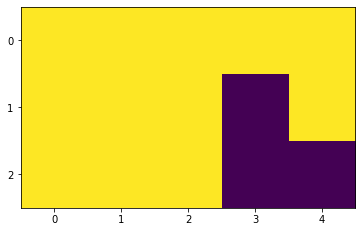

lattice after flip


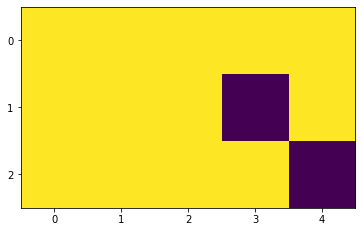

In [14]:
test=IsingModel(3,5,1,0)
print('lattice before flip')
test.plot_lattice()
test.flip_spin(2,3)
print('lattice after flip')
test.plot_lattice()


# Function to sweep the lattice in a Monte Carlo simulation

In this part of the tutorial, we will implement a function `sweep_lattice`, which will perform several Monte Carlo spin flip trials. We call it `sweep_lattice` because, on average, each spin will be selected for a Monte Carlo trial once during a 'sweep' of the lattice. For this intent, we will pick randomly one site of the lattice at every attempt. 

How many attempt do you need such that in average every site has a chance $\approx 1$  to be selected (if the grid has a size of M x N ) ? 

This will be your number of flips (num_flips) performed in this function 






In [15]:
def sweep_lattice(isingmodel, kT):

    """
    Perform N*M Monte Carlo spin flip attempts
    
    parameters:
        isingModel: Ising lattice model object instance
        kT: Boltzmann constant times temperature, $kT$
    returns:
        fraction of Monte Carlo proposals accepted
    """
    
    
    
    num_flips = isingmodel.M*isingmodel.N
    
    
    
    # keep track of number of Monte Carlo propsoals that are accepted
    
    
    n_accepted = 0
    
    
    
    for flip in range(num_flips):
        
        # choose a spin to flip at random, i and j are the horizontal/vertical indices
        
        i = np.random.randint(0,isingmodel.M)
        j = np.random.randint(0,isingmodel.N)
        
        # calculate old energy of spin at i,j 
        E_old = isingmodel.calculate_energy_of_spin(i, j)
        
        # flip the spin i,j
        isingmodel.flip_spin(i, j)    
        
        
        # calculate new energy of spin at i,j
        
        E_new = isingmodel.calculate_energy_of_spin(i, j)
        
        # Monte Carlo: accept this proposal with probability e^{-\beta \Delta E}
        
        # Define Probability P from E_new and E_old 
        
        P = np.exp(-(E_new-E_old)/kT)
        
        
        if np.random.uniform(0, 1) > P :
            
            # reject move, flip spin back to original state
            
            isingmodel.flip_spin(i, j)
            
        else:
            
            # else: accept, do nothing
            
            n_accepted += 1
            
            
            
            
    return 1.0 * n_accepted / (model.M * model.N)  # return fraction of MC moves accepted







# Monte Carlo simulation of the Ising Model 

We are now nearly done! We can now gather the pieces of the code we implemented to formulate a full fledge version of the Metropolis algorithm.

We will now define the highest level class "simulate", which will perform the overall calculations. 

We prepared the code for this purpose, there aren't any fill in below, but read carefully through the code and compare with the formalism and equations outlined in the lecture notes.

Question: in the Monte Carlo sampling we do not average quantities over the first few generated configurations (num_burn_sweeps below). Why is this a good practice? 






In [39]:
def simulate(isingmodel, kT, num_sweeps, num_burn_sweeps, sample_frequency,info_sim):

    
    """
    Monte Carlo simulations of Ising model in Canonical ensemble
    
    parameters:
        isingModel: Ising lattice model object instance
        kT: Boltzmann constant times temperature, $kT$
        num_sweeps: total number of Monte Carlo sweeps to perform in the simulation
        num_burn_sweeps: number of sweeps for equilibration (no samples taken during this period)
        sample_frequency: frequency at which to take samples
    """  
    
    
##############################################################################################    
    t0 = time.time()  # keep track of time ! 
        
    # Print some info 
    if info_sim:
        print("Simulating Ising model:")

        isingmodel.print_params()

        print("\tTemperature (kT) = %f" % kT)
        print("\t%d total sweeps, %d of them burn sweeps" % (
                num_sweeps, num_burn_sweeps))
        print("\t\tSampling every %d sweeps" % sample_frequency)

    # set energy and magnetization averages to zero, remember, in Monte Carlo we will
    # average quantities over a set of "well-chosen" configuration, those are our averages
##############################################################################################    

    

    
    energy_samples        = np.zeros(np.int((num_sweeps - num_burn_sweeps) // sample_frequency,))
    magnetization_samples = np.zeros(np.int((num_sweeps - num_burn_sweeps) // sample_frequency,))
    
    
    # keep track of number of samples taken
    
    n_samples = 0
    
    # keep track of fraction of proposals accepted, how often do we reject/accept 
    
    fraction_accepted_during_sampling_sweeps = 0
    
    # let's get the show started !!!!!!
    
############################################################################################## 
# MONTE CARLO SAMPLING
##############################################################################################    

    for sweep in range(num_sweeps):
        
        # sweep lattice, remember sweet_lattice returns the fraction of accepted trials
        
        fraction_accepted = sweep_lattice(model, kT)

        # if burn sweeps are done, take samples
        
        if sweep >= num_burn_sweeps:
            
            fraction_accepted_during_sampling_sweeps += fraction_accepted
                
            energy_samples[n_samples]        = model.calculate_lattice_energy_per_spin()
                
            magnetization_samples[n_samples] = model.calculate_net_magnetization_per_spin()
                
            n_samples += 1

##############################################################################################    



    print("\t\tFraction proposals accepted during sampling regime = %f" % (
        1.0 * fraction_accepted_during_sampling_sweeps / (num_sweeps - num_burn_sweeps)))
    
    print("\t<E> = %f +/- %f" % (np.mean(energy_samples),
                                 1.96 * np.std(energy_samples) / np.sqrt(n_samples)))
    
    print("\t<m> = %f +/- %f" % (np.mean(magnetization_samples), 
                                 1.96 * np.std(magnetization_samples) / np.sqrt(n_samples)))
    
    
    print("\tSimulation finished. Took %s sec." % (time.time() - t0))
    
    
    assert((num_sweeps - num_burn_sweeps) / sample_frequency)
    
    return energy_samples, magnetization_samples





In [19]:
a=np.zeros(np.int(10.))
print(a)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# An example Monte Carlo simulation of the Ising Model

We note set up a full simulations. First, define a 20x20 grid for the Ising model with $J=2$ and $h=0$.

In [25]:
model=IsingModel(20,10,2,0)

Now that our Ising model is all set, we run the Monte Carlo simulation with $kT=1.2$, 2000 lattice sweep, and we discard the first 1000 (burn in)

		Fraction proposals accepted during sampling regime = 0.000000
	<E> = -4.000000 +/- 0.000000
	<m> = 1.000000 +/- 0.000000
	Simulation finished. Took 1.3424289226531982 sec.


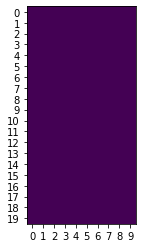

In [41]:
kT=1.2
energy_samples, magnetization_samples = simulate(model, kT, 200, 10, 1,False)
#simulate(isingmodel, kT, num_sweeps, num_burn_sweeps, sample_frequency)

model.plot_lattice()


In [42]:
for kT in np.arange(0.1,4,0.5):
    energy_samples, magnetization_samples = simulate(model, kT, 200, 10, 1,False)

    en_mean=np.mean(energy_samples)
    mag_mean=np.mean(magnetization_samples)
    
    print(kT,en_mean,mag_mean)

		Fraction proposals accepted during sampling regime = 0.000000
	<E> = -4.000000 +/- 0.000000
	<m> = 1.000000 +/- 0.000000
	Simulation finished. Took 1.4154160022735596 sec.
0.1 -4.0 1.0
		Fraction proposals accepted during sampling regime = 0.000000
	<E> = -4.000000 +/- 0.000000
	<m> = 1.000000 +/- 0.000000
	Simulation finished. Took 1.3301177024841309 sec.
0.6 -4.0 1.0
		Fraction proposals accepted during sampling regime = 0.000000
	<E> = -4.000000 +/- 0.000000
	<m> = 1.000000 +/- 0.000000
	Simulation finished. Took 1.315838098526001 sec.
1.1 -4.0 1.0
		Fraction proposals accepted during sampling regime = 0.000053
	<E> = -4.000000 +/- 0.000000
	<m> = 1.000000 +/- 0.000000
	Simulation finished. Took 1.3198177814483643 sec.
1.6 -4.0 1.0
		Fraction proposals accepted during sampling regime = 0.001947
	<E> = -3.986474 +/- 0.004767
	<m> = 0.998158 +/- 0.000657
	Simulation finished. Took 1.324167013168335 sec.
2.1 -3.9864736842105266 0.9981578947368422
		Fraction proposals accepted during 

Extend now the code above to repeat the calculation for temperatures between $kT=0$ and $kT=4$, with intervals of $kT=0.5$. Store the results in a NumPy array, and plot both the magnetization and energy

Question: do you see any changes in the energy and magnetization near $kT \approx 2.3$ ? What is your interpretation of this phenomena?

Answer : .........